<a href="https://colab.research.google.com/github/Vik-Gt-321/SkimLit/blob/main/SkimLit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool1D

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [ ]:
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign"

In [ ]:
filenames = [data_dir + "/"+ filename for filename in os.listdir(data_dir)]
filenames[0]

'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt'

## Preprocess Data

In [ ]:
def get_lines(filename):
  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
train_lines = get_lines(filenames[0])
test_lines = get_lines(filenames[1])
valid_lines = get_lines(filenames[2])

In [ ]:
train_lines[:5]

['###24290286\n',
 'BACKGROUND\tIgE sensitization to Aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .\n',
 'BACKGROUND\tIt is not clear whether these patients would benefit from antifungal treatment .\n',
 'OBJECTIVE\tWe sought to determine whether a @-month course of voriconazole improved asthma-related outcomes in patients with asthma who are IgE sensitized to A fumigatus .\n',
 'METHODS\tAsthmatic patients who were IgE sensitized to A fumigatus with a history of at least @ severe exacerbations in the previous @ months were treated for @ months with @ mg of voriconazole twice daily , followed by observation for @ months , in a double-blind , placebo-controlled , randomized design .\n']

In [ ]:
def preprocess_text(filename):
  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples =[]

  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""
    elif line.isspace():
      abstract_linesplit=  abstract_lines.splitlines()

      for abstract_line_no, abstract_line in enumerate(abstract_linesplit):
        line_data  ={}
        target_text_split = abstract_line.split("\t")
        line_data["Target"] = target_text_split[0]
        line_data["Text"] = target_text_split[1].lower()
        line_data["line_no"] = abstract_line_no
        line_data["total_lines"] =len(abstract_linesplit)-1
        abstract_samples.append(line_data)

    else:
      abstract_lines += line

  return abstract_lines

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [ ]:
%%time
train_samples = preprocess_text_with_line_numbers(data_dir+ "/" + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir +"/" + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir +"/" + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 493 ms, sys: 106 ms, total: 599 ms
Wall time: 603 ms


In [ ]:
train_samples[:3]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11}]

In [ ]:
train_df = pd.DataFrame(train_samples)
test_df =pd.DataFrame(test_samples)
val_df = pd.DataFrame(val_samples)

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


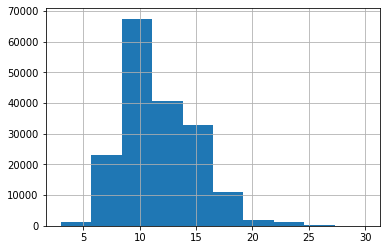

In [ ]:
train_df.total_lines.hist()

In [ ]:
train_sent = train_df.text.to_list()
test_sent = test_df.text.to_list()
val_sent = val_df.text.to_list()

In [ ]:
from sklearn.preprocessing import OneHotEncoder
one_hot = OneHotEncoder(sparse = 0)
train_labels_one_hot =one_hot.fit_transform(train_df.target.to_numpy().reshape((-1,1)))
val_labels_one_hot = one_hot.fit_transform(val_df.target.to_numpy().reshape((-1,1)))
test_labels_one_hot = one_hot.fit_transform(test_df.target.to_numpy().reshape((-1,1)))

## Label Encode labels

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
label_enc= LabelEncoder()
train_labels_labelled = label_enc.fit_transform(train_df.target.to_numpy())
test_labels_labelled = label_enc.fit_transform(test_df.target.to_numpy())
val_labels_labelled = label_enc.fit_transform(val_df.target.to_numpy())

In [ ]:
class_names = label_enc.classes_
num_classes = len(class_names)
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [ ]:
train_labels_labelled

array([3, 2, 2, ..., 4, 1, 1])

## Baseline Model

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([("tfidf",TfidfVectorizer()),
                    ("Nb", MultinomialNB())
                    ])
model_0.fit(train_sent, train_labels_labelled)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('Nb',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [ ]:
model_0.score(val_sent, val_labels_labelled)

0.7218323844829869

In [ ]:
baseline_preds = model_0.predict(val_sent)

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-08-08 14:19:57--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-08-08 14:19:58 (76.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

In [ ]:
baseline_results = calculate_results(val_labels_labelled, baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

In [ ]:
sent_lens = [len(sentence.split()) for sentence in train_sent]
avg_sent_len = np.mean(sent_lens)

In [ ]:
x ="Hello viks"
x.split()

['Hello', 'viks']

In [ ]:
len(x.split())

2

In [ ]:
avg_sent_len

26.338269273494777

In [ ]:
int(np.percentile(sent_lens, 95))

55

In [ ]:
int(np.percentile(sent_lens, 100))

296

In [ ]:
max(sent_lens)
max_tokens = 68000

## Text Vect and Embed

In [ ]:
text_vect = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens = max_tokens,output_sequence_length = 55, 
)

In [ ]:
text_vect.adapt(train_sent)

In [ ]:
text_sent = random.choice(train_sent)
print(f"Text:\n{text_sent}")
print(len(text_sent))
print(text_vect([text_sent]))

Text:
this study is the first long-term follow-up of a randomized controlled trial with supplementation of dha and aa to human milk fed vlbw infants investigating both cognitive functions and brain macrostructure measured by mri .
224
tf.Tensor(
[[   23    17    20     2   152   335    94     4     8    29   106    32
      7   464     4  2480     3  2065     6   631  1296  2444  5692   337
   2576    54   301  1907     3   623 53172   156    22   975     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]], shape=(1, 55), dtype=int64)


In [ ]:
rcb_20k = text_vect.get_vocabulary()
rcb_20k[:5],rcb_20k[-5:]


(['', '[UNK]', 'the', 'and', 'of'],
 ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp'])

In [ ]:
len(rcb_20k)

64841

In [ ]:
len(train_sent)

180040

In [ ]:
token_embed = tf.keras.layers.Embedding(len(rcb_20k),
                                        output_dim = 128,
                                        mask_zero = True,
                                        name = 'TokenEmbedding')

## Datasets creation

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sent, train_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sent, test_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sent, val_labels_one_hot))

In [ ]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

## Conv1D

In [ ]:
from tensorflow.keras import layers

In [ ]:
len(train_dataset), len(val_dataset)

(5627, 945)

In [ ]:
input = layers.Input(shape = (1,), dtype = tf.string)
x =text_vect(input)
x = token_embed(x)
x = layers.Conv1D(64, 5, padding ="same", activation= "relu")(x)
x = layers.GlobalAveragePooling1D()(x)
output = layers.Dense(len(class_names), activation="softmax")(x)
model_1 = tf.keras.Model(input, output, name = "Cnv1D")
model_1.summary()

Model: "Cnv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 55)                0         
_________________________________________________________________
TokenEmbedding (Embedding)   (None, 55, 128)           8299648   
_________________________________________________________________
conv1d (Conv1D)              (None, 55, 64)            41024     
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 8,340,997
Trainable params: 8,340,997
Non-trainable params: 0
___________________________________________________

In [ ]:
model_1.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_1_history = model_1.fit(train_dataset, validation_data=val_dataset,epochs =3,
                              steps_per_epoch = int(0.1*(len(train_dataset))        ),
                              validation_steps = int(0.1*(len(val_dataset))) )

Epoch 1/3
562/562 [==============================] - 86s 102ms/step - loss: 0.9147 - accuracy: 0.6441 - val_loss: 0.6913 - val_accuracy: 0.7387
Epoch 2/3
562/562 [==============================] - 57s 102ms/step - loss: 0.6633 - accuracy: 0.7532 - val_loss: 0.6383 - val_accuracy: 0.7689
Epoch 3/3
562/562 [==============================] - 57s 101ms/step - loss: 0.6223 - accuracy: 0.7695 - val_loss: 0.6016 - val_accuracy: 0.7842


In [ ]:
model_1_pred_probs = model_1.predict(val_dataset)

In [ ]:
model_1_pred_probs.shape

(30212, 5)

In [ ]:
model_1_preds =model_1_pred_probs.argmax(axis =1)

In [ ]:
model_1_preds

array([0, 0, 3, ..., 4, 1, 1])

In [ ]:
model_1_results = calculate_results(val_labels_labelled, model_1_preds)

In [ ]:
model_1_results

{'accuracy': 78.53170925460083,
 'f1': 0.7827318298454311,
 'precision': 0.7822206462798679,
 'recall': 0.7853170925460082}

## USE

In [ ]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embeddings = embed(["hello i am viks"])

In [ ]:
tf_embed_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                trainable = 0)

In [ ]:
model_2 = Sequential([
                      layers.Input(shape =[], dtype  =tf.string),
                      tf_embed_layer,
                      layers.Dense(128, activation="relu"),
                      layers.Dense(5, activation="softmax")])
model_2.compile(loss = tf.keras.losses.categorical_crossentropy,
                metrics = ["accuracy"],
                optimizer = tf.keras.optimizers.Adam())

In [ ]:
model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 512)               256797824 
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
model_2_history = model_2.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=3,
            validation_data=val_dataset,
            validation_steps=int(0.1 * len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 13s 18ms/step - loss: 0.9186 - accuracy: 0.6506 - val_loss: 0.7963 - val_accuracy: 0.6882
Epoch 2/3
562/562 [==============================] - 10s 17ms/step - loss: 0.7689 - accuracy: 0.7012 - val_loss: 0.7557 - val_accuracy: 0.7021
Epoch 3/3
562/562 [==============================] - 9s 17ms/step - loss: 0.7538 - accuracy: 0.7120 - val_loss: 0.7411 - val_accuracy: 0.7124


In [ ]:
def change_probs2preds(model):
  probs = model.predict(val_dataset)
  preds = probs.argmax(axis =1)
  results = calculate_results(val_labels_labelled, preds)
  return results

In [ ]:
model_2_results = change_probs2preds(model_2)

In [ ]:
model_2_results

{'accuracy': 71.44512114391632,
 'f1': 0.7114517973533913,
 'precision': 0.7148291611189592,
 'recall': 0.7144512114391632}

## Conv1D with character embeddings

In [ ]:
def split_chars(text):
  return " ".join(list(text))

In [ ]:
train_chars = [split_chars(sent) for sent in train_sent ]
test_chars = [split_chars(sent) for sent in test_sent]
val_chars = [split_chars(sent) for sent in val_sent]

In [ ]:
train_chars[:2]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .']

In [ ]:
char_lens=  [len(sent) for sent in train_sent ]
avg_charlen = np.mean(char_lens)
avg_charlen

149.3662574983337

(array([7.8590e+03, 3.5206e+04, 4.9626e+04, 4.0112e+04, 2.4025e+04,
        1.2206e+04, 5.8610e+03, 2.5790e+03, 1.2490e+03, 6.2200e+02,
        3.1400e+02, 1.5300e+02, 8.8000e+01, 5.1000e+01, 2.8000e+01,
        1.7000e+01, 1.7000e+01, 8.0000e+00, 5.0000e+00, 6.0000e+00,
        2.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.00000000e+00, 4.71666667e+01, 9.33333333e+01, 1.39500000e+02,
        1.85666667e+02, 2.31833333e+02, 2.78000000e+02, 3.24166667e+02,
        3.70333333e+02, 4.16500000e+02, 4.62666667e+02, 5.08833333e+02,
        5.55000000e+02, 6.01166667e+02, 6.47333333e+02, 6.93500000e+02,
        7.39666667e+02, 7.85833333e+02, 8.32000000e+02, 8.78166667e+02,
        9.24333333e+02, 9.70500000e+02, 1.01666667e+03, 1.06283333e+03,
        1.10900000e+03, 1.15516667e+03, 1.20133333e+03, 1.24750000e+03,
        1.29366667e+03, 1.33983333e+03, 1.38600000e+03]),
 <a list of 30 Patch objects

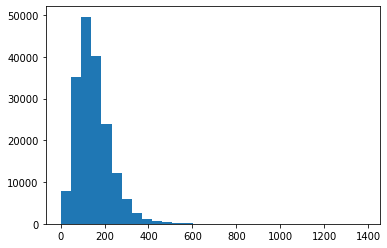

In [ ]:
plt.hist(char_lens, bins = 30)

In [ ]:
output_seq_char_len = np.percentile(char_lens, 95)

In [ ]:
import string
alphabet =string.ascii_lowercase + string.digits + string.punctuation

In [ ]:
NUM_CHAR_TOKENS = len(alphabet) + 2

In [ ]:
char_vect = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                              output_sequence_length = int(output_seq_char_len))

In [ ]:
char_vect.adapt(train_chars)
char_vocab = char_vect.get_vocabulary()

In [ ]:
char_embed = layers.Embedding(input_dim = len(char_vocab),
                              output_dim = 25,
                              mask_zero =1)

In [ ]:
input = layers.Input(shape  =(1,), dtype =tf.string)
x = char_vect(input)
x = char_embed(x)
x = layers.Conv1D(128, 5, activation="relu", padding="same")(x)
x = layers.GlobalMaxPool1D()(x)
output = layers.Dense(5, activation="softmax")(x)
model_3 = tf.keras.Model(input, output, name = "ConvChar")

In [ ]:
model_3.summary()

Model: "ConvChar"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 290)               0         
_________________________________________________________________
embedding (Embedding)        (None, 290, 25)           700       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 290, 128)          16128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 645       
Total params: 17,473
Trainable params: 17,473
Non-trainable params: 0
______________________________________________________

In [ ]:
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
train_dataset_char = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset_char  = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset_char = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
model_3.fit(train_dataset_char, validation_data=val_dataset_char, steps_per_epoch=int(0.1*len(train_dataset_char)),
            validation_steps = int(0.1*len(val_dataset_char)),epochs =3)

Epoch 1/3
562/562 [==============================] - 7s 11ms/step - loss: 1.2086 - accuracy: 0.5105 - val_loss: 0.9783 - val_accuracy: 0.6177
Epoch 2/3
562/562 [==============================] - 6s 10ms/step - loss: 0.9458 - accuracy: 0.6280 - val_loss: 0.8694 - val_accuracy: 0.6632
Epoch 3/3
562/562 [==============================] - 6s 10ms/step - loss: 0.8675 - accuracy: 0.6644 - val_loss: 0.8175 - val_accuracy: 0.6809


In [ ]:
model_3_pred_probs = model_3.predict(val_dataset_char)
model_3_pred_probs

array([[0.17011708, 0.3901133 , 0.04617317, 0.3744311 , 0.01916528],
       [0.12603398, 0.5092043 , 0.01014387, 0.3267727 , 0.02784513],
       [0.07618814, 0.11170778, 0.07944273, 0.70922065, 0.02344061],
       ...,
       [0.01316942, 0.02858122, 0.29178095, 0.02343798, 0.64303046],
       [0.03116063, 0.09199245, 0.34155366, 0.06478047, 0.4705128 ],
       [0.43757716, 0.40496057, 0.08659998, 0.05831257, 0.01254973]],
      dtype=float32)

In [ ]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 0])>

In [ ]:
model_3_results = calculate_results(val_labels_labelled,
                                        y_pred=model_3_preds)
model_3_results

{'accuracy': 67.60558718390044,
 'f1': 0.6615480318364979,
 'precision': 0.67930218965915,
 'recall': 0.6760558718390044}

## MultiModal Model

In [ ]:
input_token = layers.Input(shape = [], dtype = tf.string)
token_embeddings = tf_embed_layer(input_token)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(input_token, token_output)

input_char = layers.Input(shape =(1,), dtype= tf.string)
char_vectors =char_vect(input_char)
char_embeddings=  char_embed(char_vectors)
char_blistm  = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(input_char, char_blistm)

token_char_concat = layers.Concatenate()([char_model.output, token_model.output])

combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense  =layers.Dense(200, activation="relu")(combined_dropout)

final_dropout= layers.Dropout(0.5)(combined_dense)
final_dense = layers.Dense(5, activation="softmax")(final_dropout)

model_4 = tf.keras.Model(inputs =[char_model.input, token_model.input],
                         outputs = final_dense)

In [ ]:
model_4.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
text_vectorization_1 (TextVecto (None, 290)          0           input_5[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 290, 25)      700         text_vectorization_1[1][0]       
____________________________________________________________________________________________

In [ ]:
from tensorflow.keras.utils import plot_model

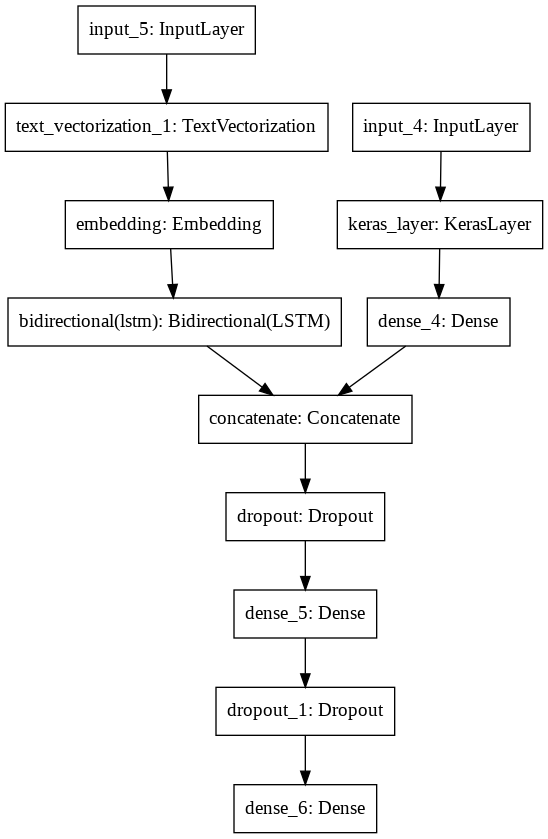

In [ ]:
plot_model(model_4)

In [ ]:
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["accuracy"])

In [ ]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sent, train_chars))
train_char_token_labesl = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labesl))
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sent, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
model_4.fit(train_char_token_dataset, validation_data=val_char_token_dataset, epochs= 3,
            validation_steps = int(0.1*(len(val_char_token_dataset))),
            steps_per_epoch =int(0.1*(len(train_char_token_dataset))) )

Epoch 1/3
562/562 [==============================] - 51s 74ms/step - loss: 1.2895 - accuracy: 0.4478 - val_loss: 1.1519 - val_accuracy: 0.5236
Epoch 2/3
562/562 [==============================] - 38s 67ms/step - loss: 1.1774 - accuracy: 0.5053 - val_loss: 1.1051 - val_accuracy: 0.5369
Epoch 3/3
562/562 [==============================] - 35s 62ms/step - loss: 1.1394 - accuracy: 0.5258 - val_loss: 1.0693 - val_accuracy: 0.5615


In [ ]:
model_4_probs = model_4.predict(val_char_token_dataset)

In [ ]:
model_4_preds = model_4_probs.argmax(axis = 1)

In [ ]:
model_4_preds

array([1, 4, 2, ..., 1, 2, 0])

In [ ]:
model_4_results = calculate_results(val_labels_labelled, model_4_preds)

In [ ]:
model_4_results

{'accuracy': 55.7957103137826,
 'f1': 0.5255192049765567,
 'precision': 0.5904808814372406,
 'recall': 0.557957103137826}

## Transfer Learning with Token, character and positional embeddings

### Create positional Embeddings

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [ ]:
train_line_no_onehot = tf.one_hot(train_df.line_number.to_numpy(), depth = 15)
val_line_no_onehot = tf.one_hot(val_df.line_number.to_numpy(), depth =15)
test_line_no_onehot = tf.one_hot(test_df.line_number.to_numpy(), depth= 15)

In [ ]:
train_df.total_lines.value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

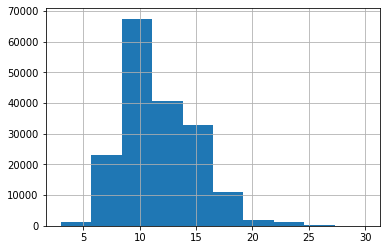

In [ ]:
train_df.total_lines.hist()

In [ ]:
train_tline_onehot = tf.one_hot(train_df.total_lines.to_numpy(), depth=20)
val_tline_onehot = tf.one_hot(val_df.total_lines.to_numpy(), depth=20)
test_tline_onehot = tf.one_hot(test_df.total_lines.to_numpy(), depth = 20)

In [ ]:
train_tline_onehot[:3]

<tf.Tensor: shape=(3, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [ ]:
token_input = layers.Input(shape = [], dtype = tf.string)
token_embeddings = tf_embed_layer(token_input)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs = token_input, outputs = token_outputs)

char_inputs = layers.Input(shape = (1,), dtype = tf.string)
char_vectors = char_vect(char_inputs)
char_embeddings  = char_embed(char_vectors)
char_blistm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
#char_outputs = layers.Dense(128, activation="relu")(char_blistm)
char_model = tf.keras.Model(char_inputs, char_blistm)

line_no_inputs = layers.Input(shape = (15,), dtype=tf.float32)
line_no_outputs = layers.Dense(32, activation="relu")(line_no_inputs)
line_no_model =  tf.keras.Model(line_no_inputs, line_no_outputs)

tline_inputs  = layers.Input(shape = (20,), dtype = tf.float32)
tline_no_outputs = layers.Dense(32, activation="relu")(tline_inputs)
tline_model = tf.keras.Model(tline_inputs, tline_no_outputs)

all_out = layers.Concatenate()([token_model.output, char_model.output])
z = layers.Dense(256, activation="relu")(all_out)
z = layers.Dropout(0.5)(z)
tribrid_embeddings = layers.Concatenate()([z, line_no_model.output, tline_model.output])

combined_output =  layers.Dense(5, activation="softmax")(tribrid_embeddings)
model_5 = tf.keras.Model(inputs = [line_no_model.input,
                                   tline_model.input,
                                   token_model.input,
                                   char_model.input], outputs = combined_output)




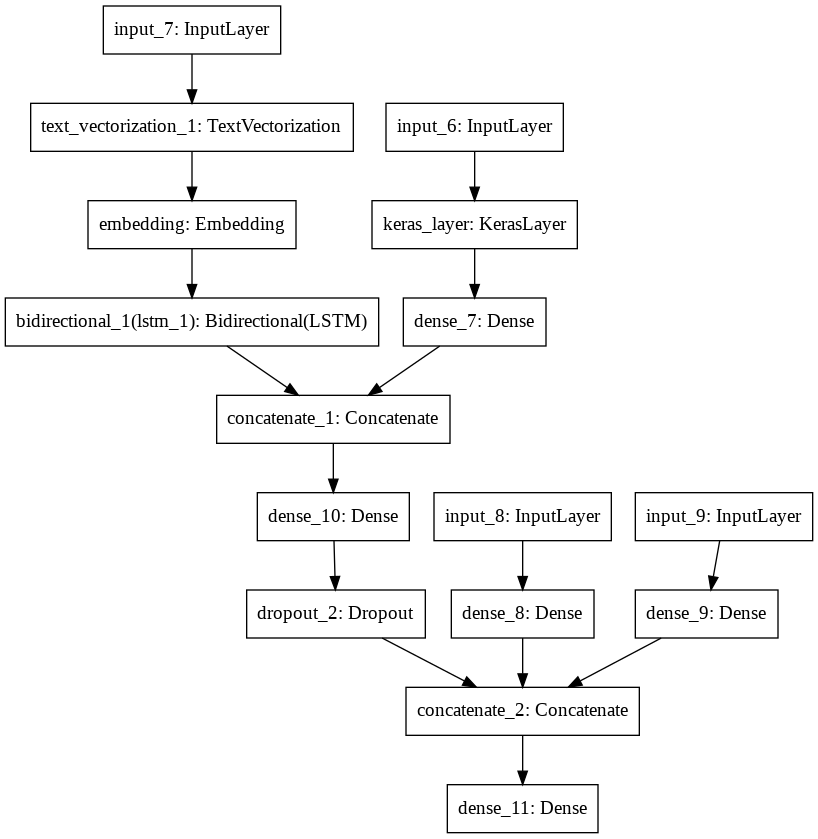

In [ ]:
plot_model(model_5)

In [ ]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
train_token_car_pos_data = tf.data.Dataset.from_tensor_slices((train_line_no_onehot, train_tline_onehot,
                                                               train_sent, train_chars))
train_token_char_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_token_char_pos_dataset = tf.data.Dataset.zip((train_token_car_pos_data, train_token_char_pos_labels))
train_token_char_pos_dataset = train_token_char_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_token_car_pos_data = tf.data.Dataset.from_tensor_slices((val_line_no_onehot, val_tline_onehot,
                                                               val_sent, val_chars))
val_token_char_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_token_char_pos_dataset = tf.data.Dataset.zip((val_token_car_pos_data, val_token_char_pos_labels))
val_token_char_pos_dataset = val_token_char_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_token_car_pos_data = tf.data.Dataset.from_tensor_slices((test_line_no_onehot, test_tline_onehot,
                                                               test_sent, test_chars))
test_token_char_pos_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_token_char_pos_dataset = tf.data.Dataset.zip((test_token_car_pos_data, test_token_char_pos_labels))
test_token_char_pos_dataset = test_token_char_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
model_5_history = model_5.fit(train_token_char_pos_dataset, validation_data=val_token_char_pos_dataset,
                              epochs =3, steps_per_epoch = int(0.1*(len(train_token_char_pos_dataset))),
                              validation_steps = int(0.1*(len(val_token_char_pos_dataset))))

Epoch 1/3
562/562 [==============================] - 82s 129ms/step - loss: 1.1001 - accuracy: 0.7194 - val_loss: 0.9842 - val_accuracy: 0.8045
Epoch 2/3
562/562 [==============================] - 71s 127ms/step - loss: 0.9690 - accuracy: 0.8148 - val_loss: 0.9513 - val_accuracy: 0.8271
Epoch 3/3
562/562 [==============================] - 67s 119ms/step - loss: 0.9520 - accuracy: 0.8205 - val_loss: 0.9387 - val_accuracy: 0.8331


In [ ]:
model_5_pred_probs = model_5.predict(val_token_char_pos_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 50s 49ms/step


array([[0.49586046, 0.11105602, 0.01056406, 0.36403582, 0.01848366],
       [0.5474625 , 0.10244343, 0.05219147, 0.2871696 , 0.01073294],
       [0.27923006, 0.11088356, 0.13961256, 0.40091825, 0.06935555],
       ...,
       [0.02969134, 0.10605203, 0.04461521, 0.02815508, 0.7914864 ],
       [0.02868934, 0.3042286 , 0.07108591, 0.02699471, 0.56900144],
       [0.23385596, 0.5459194 , 0.11545445, 0.04479321, 0.05997691]],
      dtype=float32)

In [ ]:
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
model_5_results = calculate_results(y_true=val_labels_labelled,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.27154772937905,
 'f1': 0.8317233571680405,
 'precision': 0.8315004790154155,
 'recall': 0.8327154772937906}

In [ ]:

# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.531709,0.782221,0.785317,0.782732
pretrained_token_embed,71.445121,0.714829,0.714451,0.711452
custom_char_embed_conv1d,67.605587,0.679302,0.676056,0.661548
hybrid_char_token_embed,55.795710,0.590481,0.557957,0.525519
tribrid_pos_char_token_embed,83.271548,0.831500,0.832715,0.831723


In [ ]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100

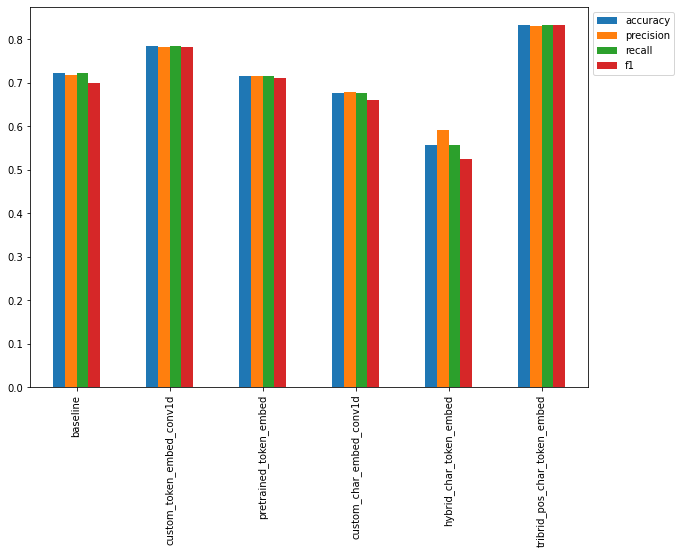

In [ ]:
all_model_results.plot(figsize = (10,7), kind = "bar").legend(bbox_to_anchor=(1.0,1.0))

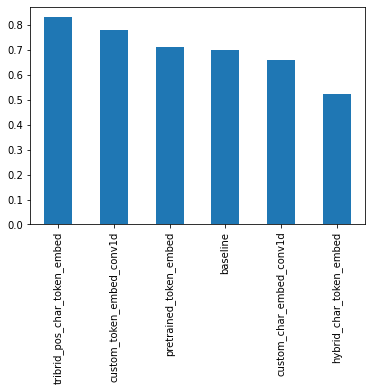

In [ ]:
all_model_results.sort_values("f1", ascending = 0)["f1"].plot(kind = "bar")

In [ ]:
model_5.save("skimlit_tribrid_model") 

INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
!mkdir skimlit_gs_model
!unzip skimlit_tribrid_model.zip -d skimlit_gs_model

--2021-08-08 14:42:46--  https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.157.128, 74.125.23.128, 74.125.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.157.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 962957902 (918M) [application/zip]
Saving to: ‘skimlit_tribrid_model.zip’

skimlit_tribrid_mod 100%[===================>] 918.35M  72.6MB/s    in 14s     

2021-08-08 14:43:01 (67.5 MB/s) - ‘skimlit_tribrid_model.zip’ saved [962957902/962957902]

Archive:  skimlit_tribrid_model.zip
   creating: skimlit_gs_model/skimlit_tribrid_model/
   creating: skimlit_gs_model/skimlit_tribrid_model/assets/
   creating: skimlit_gs_model/skimlit_tribrid_model/variables/
  inflating: skimlit_gs_model/skimlit_tribrid_model/variables/variables.index  
  inflating: skimlit_gs_model/skimlit_tribrid_model/variables/variables.data-00000-of-00001 

In [ ]:
loaded_model = tf.keras.models.load_model("skimlit_tribrid_model")

In [ ]:
test_token_char_pos_dataset

<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>

In [ ]:
test_pred_probs = model_5.predict(test_token_char_pos_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)

942/942 [==============================] - 46s 49ms/step


In [ ]:
loaded_model_test_results = calculate_results(y_true=test_labels_labelled,
                                              y_pred=test_preds)
loaded_model_test_results

{'accuracy': 82.84718765555003,
 'f1': 0.8273977595111462,
 'precision': 0.8270193133101837,
 'recall': 0.8284718765555003}